# Artist Picking

This tutorial will go through how to configure a callback using `'pick_event'` to drill into a data set (in this case the Titanic passanger manifest).  For a more through tutorial please see [the full interactive tutorial](https://github.com/matplotlib/interactive_tutorial) and the [API documentation](
https://matplotlib.org/3.1.0/users/event_handling.html).

This tutorial shows how to build a interaction customized to this visualization of this data set, for sets of high-level general tools see [mpldatacursors](https://github.com/joferkington/mpldatacursor/) and [mplcursors](https://github.com/anntzer/mplcursors).

In [2]:
%matplotlib widget
%run helpers/ensure_print.py

In [3]:
from matplotlib.backend_bases import MouseButton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("http://bit.ly/tscv17")


## Our plotting function

The first step is to make our selves a helper function that will "do the right thing" for our data.  To start with, this is a wrapper around `scatter`, but eventually this will also define and install the interactive functions.

We are using the `legend_elements` which was added in [Matplotlib 3.1](https://matplotlib.org/users/prev_whats_new/whats_new_3.1.0.html#legend-for-scatter) to get a nice legend for the data.

Output()

c:\Users\Adekoya Olayiwola\.conda\envs\my_env\Lib\site-packages\matplotlib\colors.py:1352: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\Users\Adekoya Olayiwola\.conda\envs\my_env\Lib\site-packages\matplotlib\colors.py:1359: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
c:\Users\Adekoya Olayiwola\.conda\envs\my_env\Lib\site-packages\matplotlib\ticker.py:547: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


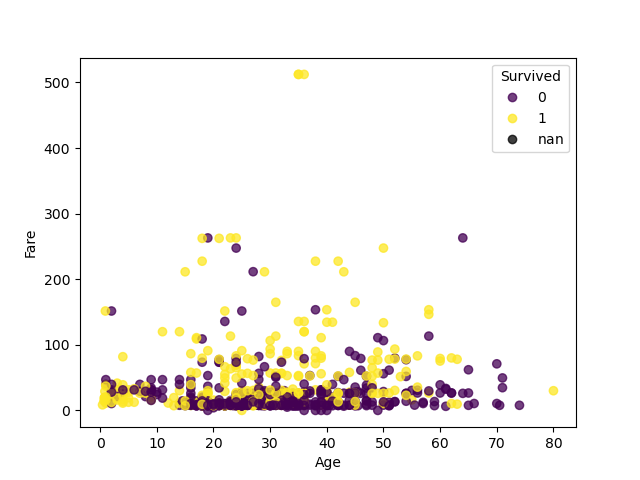

In [5]:
def make_plot(ax, data, *, x_data='Age', y_data='Fare', c_data='Survived'):
    # note use of 'data kwarg' new in mpl 1.5
    sc = ax.scatter(x_data, y_data, c=c_data, data=data, picker=5, alpha=.75) 
    ax.set(xlabel=x_data, ylabel=y_data)
    # mpl 3.1 feature
    ax.legend(*sc.legend_elements(), title=c_data)
    
fig, ax = plt.subplots()
make_plot(ax, data)

## Print a row

To get a bit more information about each point we can use the `'pick_event'` to print information about each point (aka row) to the screen.  By passing the `picker=5` to `ax.scatter` we enable picking on the resulting `PathCollection` artist.  The units on `picker` is pixels.  We can then register a callback to be called when ever the user clicks on (aka 'picks') the `Artist`.

[`PickEvent`](https://matplotlib.org/3.1.1/api/backend_bases_api.html#matplotlib.backend_bases.PickEvent) gives us access to the underlying [`MouseEvent`](https://matplotlib.org/3.1.1/api/backend_bases_api.html#matplotlib.backend_bases.MouseEvent), the `Artist` instance that was picked, and depending on the artist some additional information.  In the case of `PathCollection` (from `scatter`) and `Line2D` (from `plot`) the `PickEvent` has and `ind` attribute which is a list of the positional indexes in the input data that was picked.

The attributes on the `event` that we are going to primarily conecerned with are:

```python
def callback(event : PickEvent) -> None:
    mouse_event = event.mousevent # the underlying mouse event
    button = mouse_event.button   # the button clicked as an Enum
    ind = event.ind               # list of index of data point picked

```


Additional information (which `Axes`, the (x, y) values, keyboard keys held down) can be extract from `mouse_event` (see previous tutorial)
    

In [6]:
def make_plot(ax, data, *, x_data='Age', y_data='Fare', c_data='Survived'):

    sc = ax.scatter(x_data, y_data, c=c_data, data=data, picker=5, alpha=.75)
    ax.set(xlabel=x_data, ylabel=y_data)
    ax.legend(*sc.legend_elements(), title=c_data)
    
    # Define an inner function.  This will "close over" the input `data`
    # and our newly created artist `sc`
    def print_row(event):
        print(f'in a pick event! {event.ind} with mouse button {event.mouseevent.button}')
        # make sure we are picking the artist we care about and the left mouse button!
        if event.artist is not sc or event.mouseevent.button != MouseButton.LEFT: 
            return 

        for indx in event.ind:
            # use iloc to select a row by numeric index
            row = data.iloc[indx]
            # TODO: print something more interesting!
            print(f"hit row {indx}")
    
    # connect our call back to the canvas
    ax.figure.canvas.mpl_connect('pick_event', print_row) 
    return sc
    


Output()

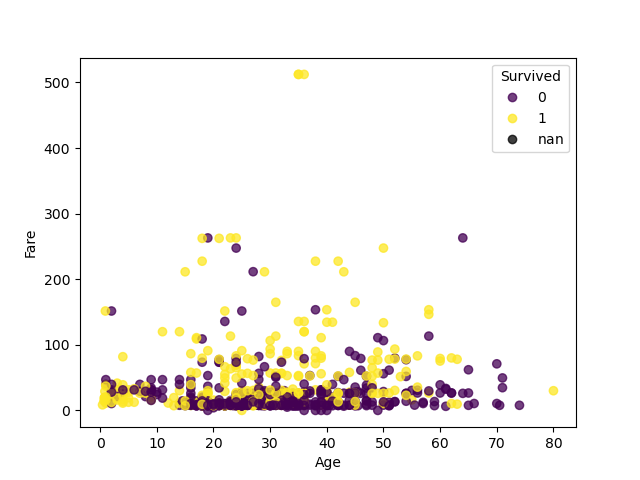

In [7]:
fig, ax = plt.subplots()
make_plot(ax, data);

## Add an annotation

We can do better than printing though, via [`ax.anotate`](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.annotate.html) we can add annotations directly to the plot.  The API an `annotate` is large, in this case we are:

- offsetting the text by \pm 50pt in each direction from the data point
- putting a transparent gray box around the text
- connect the text to the data point with a curved arrow

Output()

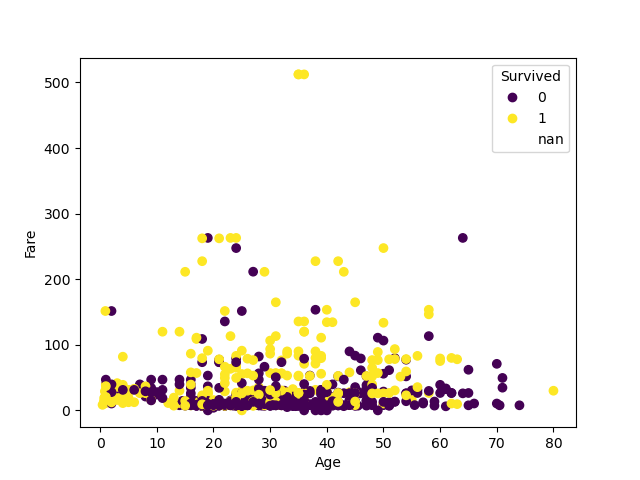

In [9]:
def make_plot(ax, data, *, x_data='Age', y_data='Fare', c_data='Survived'):
    sc = ax.scatter(x_data, y_data, c=c_data, data=data, picker=5) 
    ax.set(xlabel=x_data, ylabel=y_data)
    ax.legend(*sc.legend_elements(), 
                loc="best", title=c_data,  
                ncol=1)
    
    def add_annotation(event):
        # if this is not our artist, bail
        if event.artist is not sc or event.mouseevent.button != MouseButton.LEFT: 
            return 
        for indx in event.ind:
            # grab the row
            row = data.iloc[indx] 
            # format everything into a multi-line string
            txt = '\n'.join(['hit row', f'{indx}']) 
            ann = ax.annotate(s=txt, 
                              # update this to point someplace more sensible!
                              xy=(0, 0),  
                              # styling
                              # make the box light gray and transparent
                              bbox={'color': '.1', 'alpha': .2},
                              # offset text randomly by a few points
                              xytext=(np.random.rand(2) - .5) * 100,
                              textcoords='offset points', 
                              # connect text to point with a curved arrow
                              arrowprops=dict(
                                  arrowstyle="->", 
                                  connectionstyle="angle3,angleA=0,angleB=-90") 
                ) 
            # make it movable!
            ann.draggable()
            
        # trigger a re-draw at the next possible time
        ax.figure.canvas.draw_idle() 
    # connect our function
    ax.figure.canvas.mpl_connect('pick_event', add_annotation) 
 
fig, ax = plt.subplots()
make_plot(ax, data)  

### Exercise

Adjust the annotaiton to point at the data point (not (0, 0))

## Bonus: remove the annotations

If we can _add_ annotations, we should also be able to remove them.  All Matplotlib aritsts have a `art.remove()` method that will remove them from their parent in the draw tree.  Thus, with a bit of book-keeping we can remove the annotation on right (aka middle) click

In [10]:
def make_plot(ax, data, *, x_data='Age', y_data='Fare', c_data='Survived'):

    sc = ax.scatter(x_data, y_data, c=c_data, data=data, picker=5, alpha=.75) 
    ax.set_xlabel(x_data)
    ax.set_ylabel(y_data)
    ax.legend(*sc.legend_elements(), title=c_data)
    # someplace to stash our Annotation artists
    annotations = set()
    def add_annotation(event):
        if event.artist is not sc: 
            return 
        if event.mouseevent.button != MouseButton.LEFT: 
            return 
        
        for indx in event.ind: 
            row = data.iloc[indx] 
            txt = '\n'.join(f'{k}: {v}' for k, v in row.items()) 

            ann = ax.annotate(txt, 
                              (row[x_data], row[y_data]),  
                              # make the annotation also pickable
                              picker=1,
                              # style
                              bbox={'color': '.1', 'alpha': .2},  
                              xytext=(np.random.rand(2) - .5) * 100, 
                              textcoords='offset points', 
                              arrowprops=dict(
                                  arrowstyle="->", 
                                  connectionstyle="angle3,angleA=0,angleB=-90") 
                ) 
            ann.draggable()
            # also add the artist to the stash
            annotations.add(ann)
        ax.figure.canvas.draw_idle()
    
    # call back for _removing_ the annotations
    def remove_annotation(event): 
        # if the artist is not in annotations, bail!
        if event.artist not in annotations: 
            return 
        
        if event.mouseevent.button == MouseButton.RIGHT:
            # grab the artist to be efficent
            art = event.artist
            # remove the annotation from the figure
            art.remove()
            # remove the annotation from our stash
            annotations.remove(art)
            # ask the figure to re-draw
            ax.figure.canvas.draw_idle() 
 
    # register both of the callbacks
    ax.figure.canvas.mpl_connect('pick_event', add_annotation)
    ax.figure.canvas.mpl_connect('pick_event', remove_annotation)


Output()

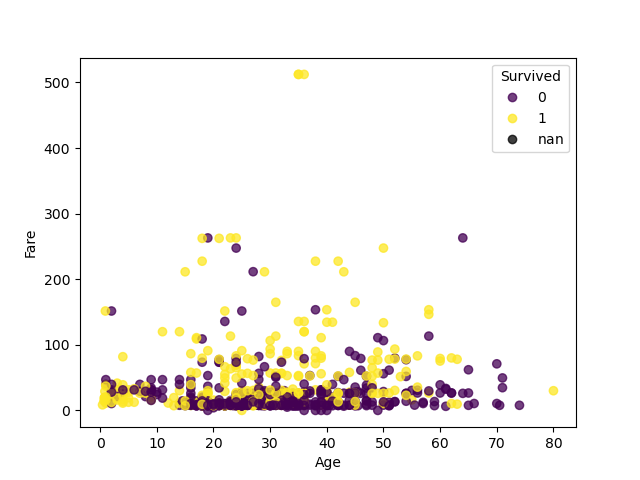

In [11]:
fig, ax = plt.subplots()
make_plot(ax, data)  